# Graph Panel 3 Analysis

This notebook analyzes the JSON files in `Copilot_1000_v0_Processed_2026-01-15_Updated_Metadata` to count "Not enough information" entries in the main subfields of `dataset`, `optimization`, `model`, and `evaluation`.


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Define paths
data_folder = 'Copilot_1000_v0_Processed_2026-01-15_Updated_Metadata'
output_folder = 'Graph_Panel_3'


In [2]:
# Verify file count
json_files = glob.glob(os.path.join(data_folder, '*.json'))
file_count = len(json_files)
print(f"Found {file_count} JSON files.")

if file_count != 1012:
    print("WARNING: Expected 1012 files.")
else:
    print("File count verification passed.")

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)
print(f"Output folder '{output_folder}' ready.")


Found 1012 JSON files.
File count verification passed.
Output folder 'Graph_Panel_3' ready.


In [10]:
# Initialize counters
# We want to count 'Not enough information' and 'Not Applicable' for each subfield within the main categories

target_missing = "not enough information"
target_na = "not applicable"

# Structure to hold data: [ { 'Category': '...', 'Subfield': '...', 'Status': '...' } ]
results = []

categories_map = {
    'dataset': 'Data',
    'optimization': 'Optimisation',
    'model': 'Model',
    'evaluation': 'Evaluation'
}

for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            
        for key, value in data.items():
            if '/' in key:
                prefix, subfield = key.split('/', 1)
                
                if prefix in categories_map:
                    category = categories_map[prefix]
                    
                    is_missing = False
                    is_na = False
                    
                    if isinstance(value, str):
                        v_lower = value.lower()
                        if target_missing in v_lower:
                            is_missing = True
                        if target_na in v_lower:
                            is_na = True
                    
                    results.append({
                        'File': os.path.basename(json_file),
                        'Category': category,
                        'Subfield': subfield,
                        'IsMissing': is_missing,
                        'IsNA': is_na
                    })
                    
    except Exception as e:
        print(f"Error processing {json_file}: {e}")

df = pd.DataFrame(results)
print(f"Processed {len(df)} records.")
df.head()

Processed 21252 records.


,File,Category,Subfield,IsMissing,IsNA
0,PMC7659093.json,Data,provenance,False,False
1,PMC7659093.json,Data,splits,False,True
2,PMC7659093.json,Data,redundancy,False,True
3,PMC7659093.json,Data,availability,False,False
4,PMC7659093.json,Optimisation,algorithm,False,False


--- Plot 1: Standard Coverage (excluding 'Not Enough Info') ---
Graph saved to Graph_Panel_3/coverage_analysis_success.png


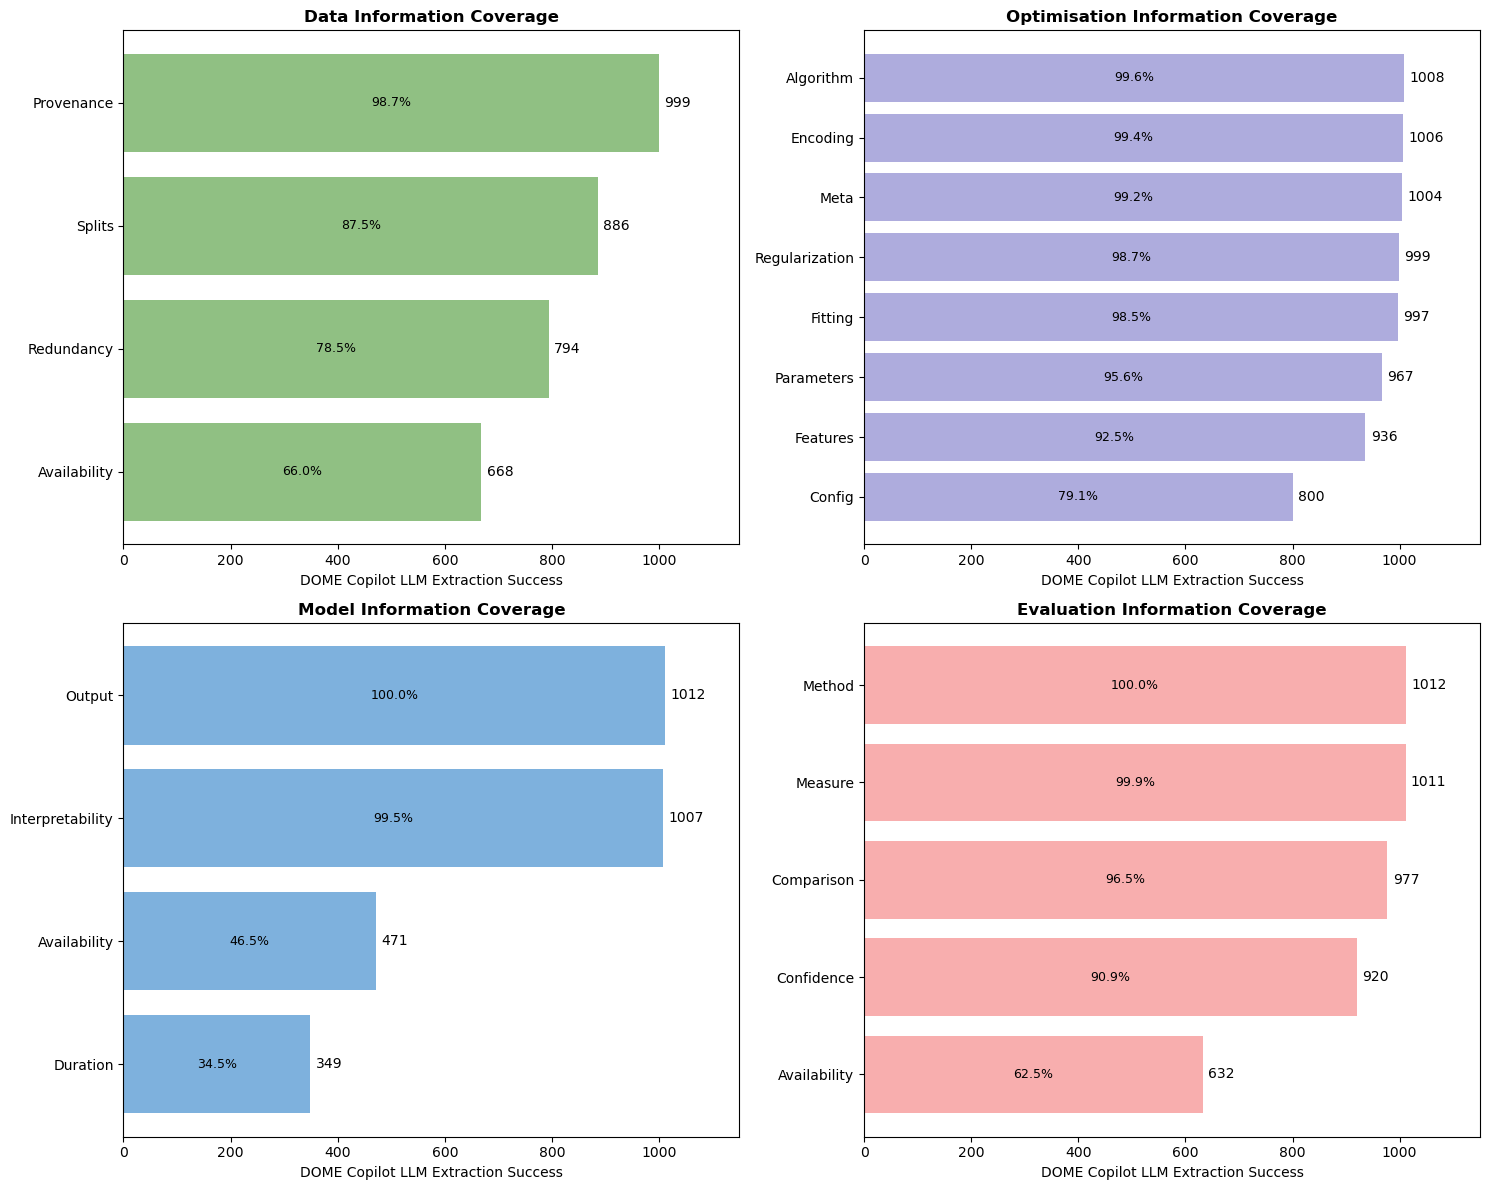

--- Plot 2: Relevance Coverage (excluding 'Not Applicable') ---
Graph saved to Graph_Panel_3/coverage_analysis_relevance.png


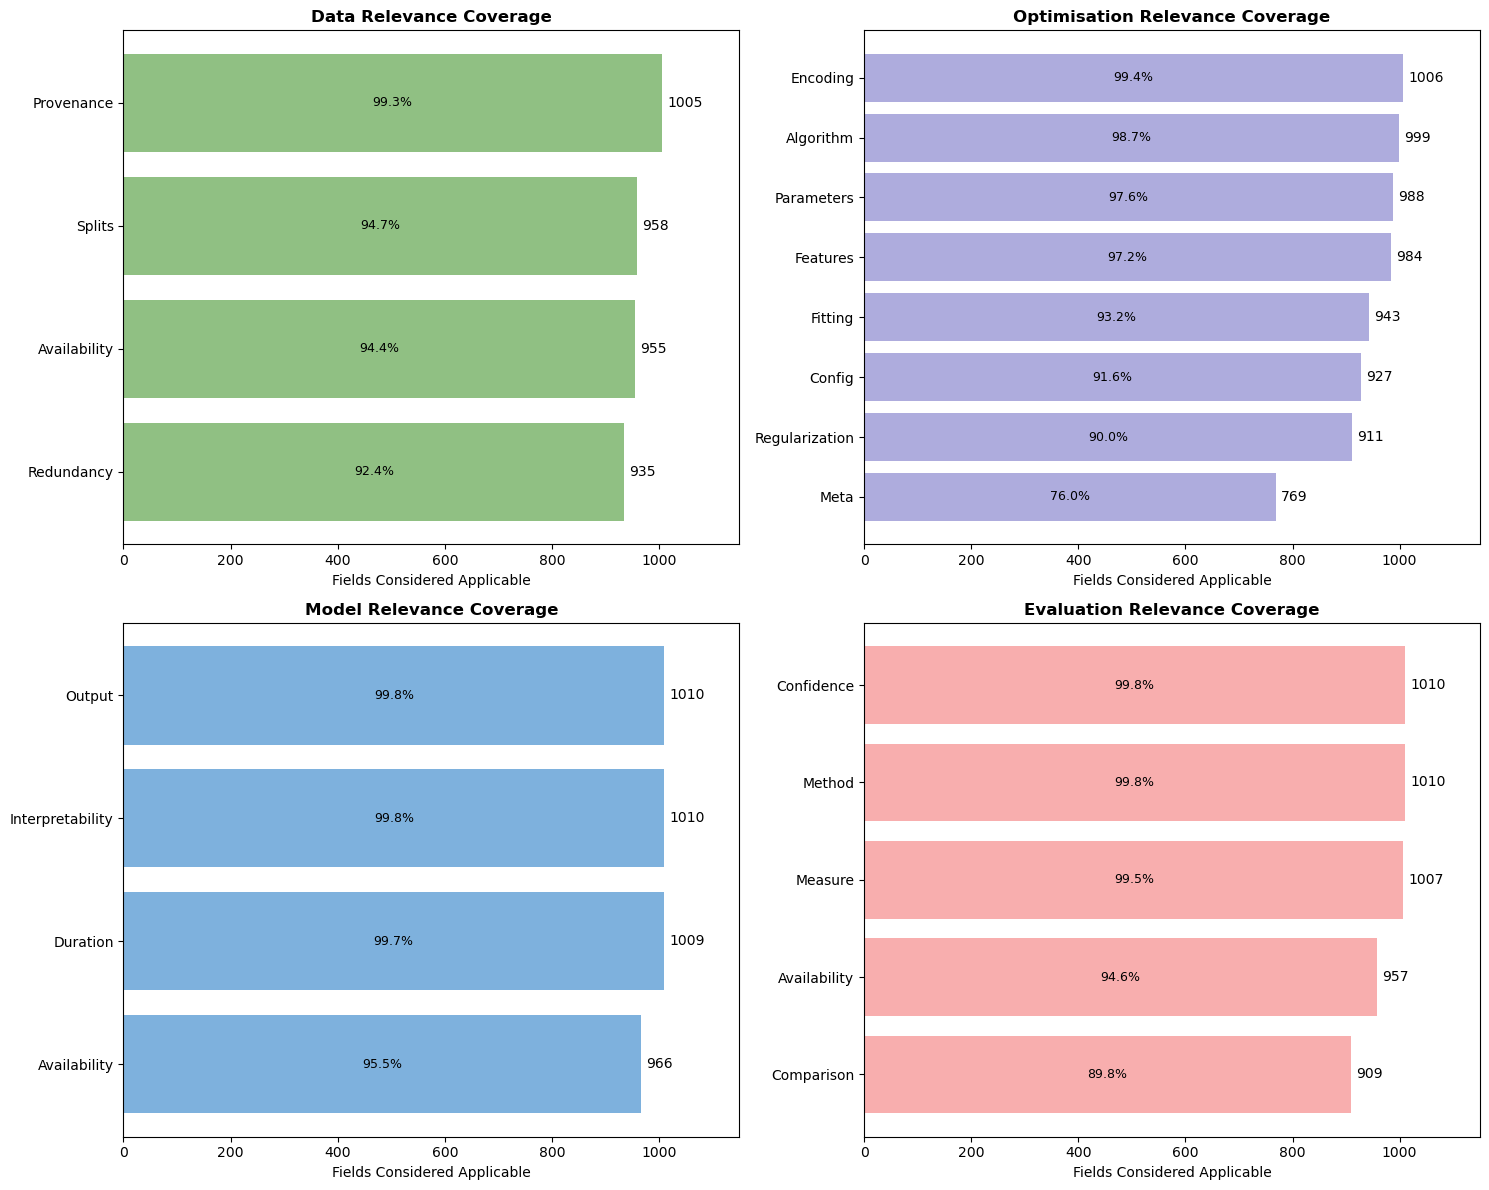

--- Plot 3: Valid Information Coverage (excluding Missing AND NA) ---
Graph saved to Graph_Panel_3/coverage_analysis_valid.png


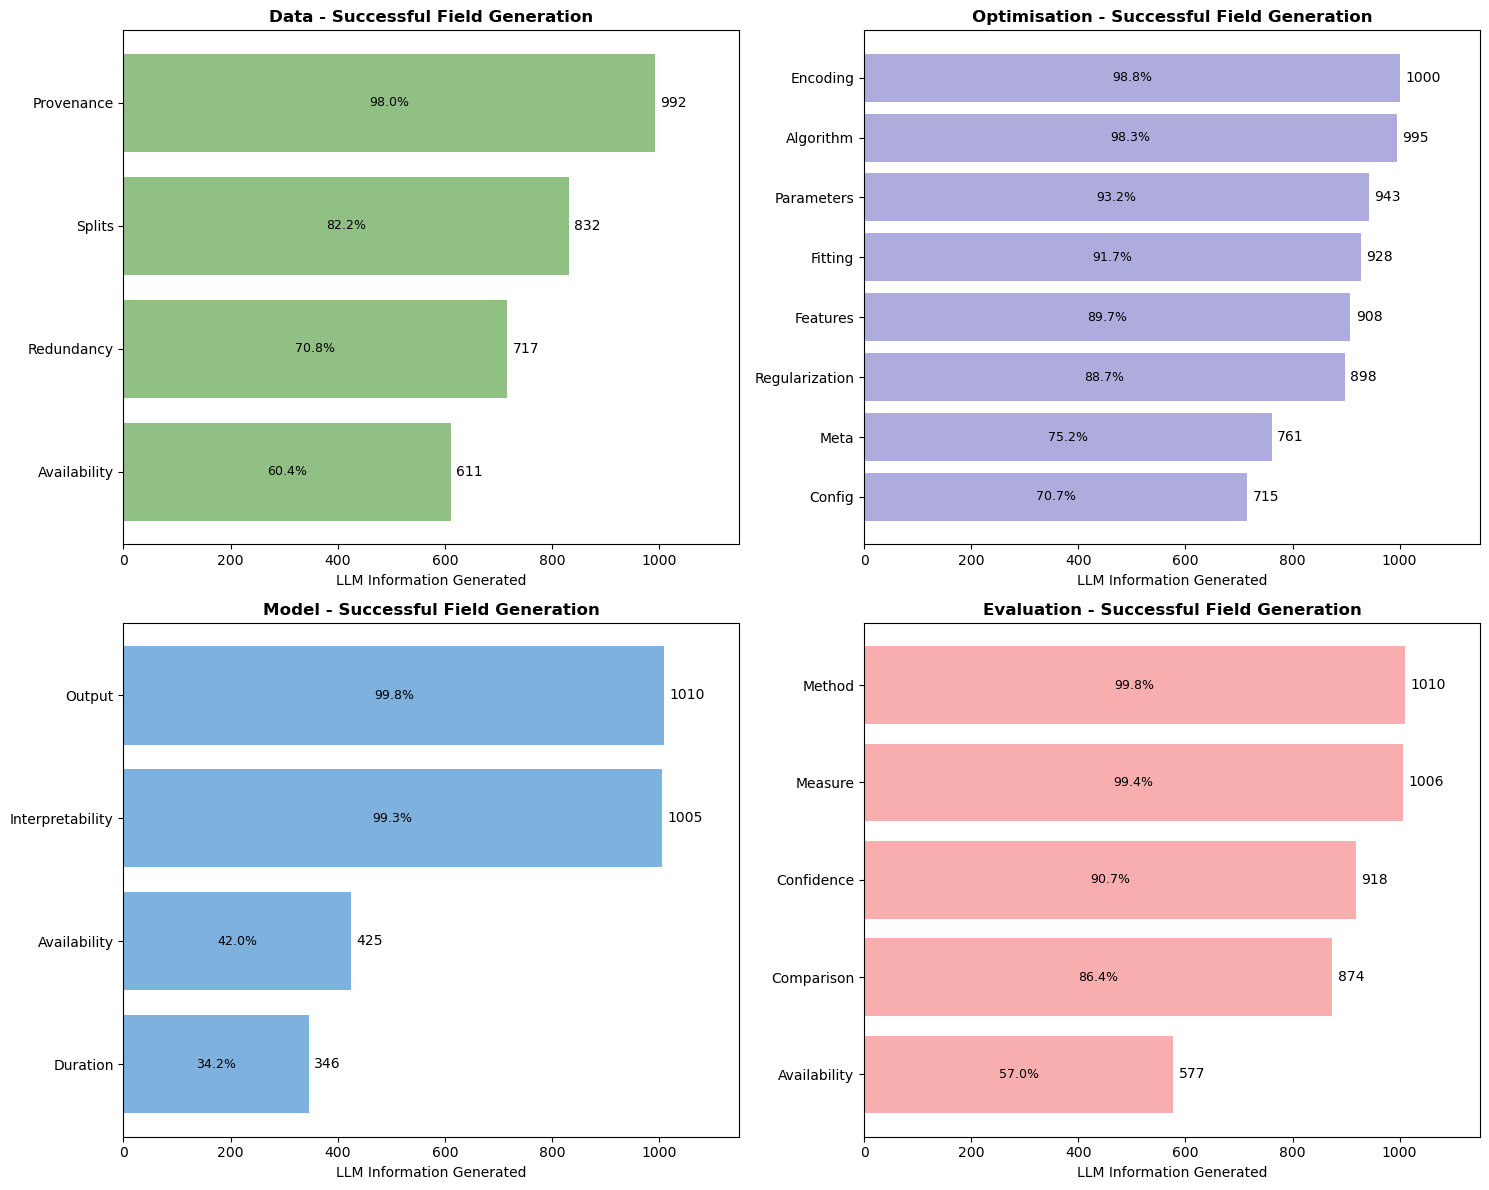

In [13]:
# --- Helper Function for Plotting ---
def create_coverage_plot(data_df, condition_col, title_suffix, xlabel, filename, invert_condition=True):
    """
    Generates a coverage plot based on a specific boolean condition.
    invert_condition=True means we count where condition is FALSE (Inverse/Coverage).
    """
    if invert_condition:
        subset_df = data_df[data_df[condition_col] == False]
    else:
        # Special case for "Valid" where we pass a pre-calculated Series or complex condition
        # If condition_col is a Series (boolean mask)
        subset_df = data_df[condition_col]

    counts = subset_df.groupby(['Category', 'Subfield']).size().reset_index(name='Count')
    
    total_files = data_df['File'].nunique()
    
    # Colors
    category_colors = {
        'Data': '#90C083', 
        'Optimisation': '#AEACDD', 
        'Model': '#7EB1DD', 
        'Evaluation': '#F8AEAE'
    }
    categories = ['Data', 'Optimisation', 'Model', 'Evaluation']
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        ax = axes[i]
        subset = counts[counts['Category'] == category]
        
        # Merge with all subfields to ensure consistency
        all_subfields = data_df[data_df['Category'] == category]['Subfield'].unique()
        full_subset = pd.DataFrame({'Subfield': all_subfields})
        full_subset = full_subset.merge(subset, on='Subfield', how='left').fillna(0)
        full_subset['Subfield'] = full_subset['Subfield'].str.capitalize()
        full_subset = full_subset.sort_values('Count', ascending=True)
        
        bar_color = category_colors.get(category, 'skyblue')
        bars = ax.barh(full_subset['Subfield'], full_subset['Count'], color=bar_color)
        
        ax.set_title(f'{category} {title_suffix}', fontweight='bold')
        ax.set_xlabel(xlabel)
        ax.set_xlim(0, 1150)
        
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 10, bar.get_y() + bar.get_height()/2, f'{int(width)}', ha='left', va='center')
            if width > 0:
                pct = (width / total_files) * 100
                ax.text(width / 2, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', ha='center', va='center', color='black', fontsize=9)

    plt.tight_layout()
    path = os.path.join(output_folder, filename)
    plt.savefig(path)
    print(f"Graph saved to {path}")
    plt.show()

# --- 1. Original Plot: Coverage (Not "Not Enough Info") ---
# Keeps the original requested logic: "Extraction Success"
print("--- Plot 1: Standard Coverage (excluding 'Not Enough Info') ---")
create_coverage_plot(
    df, 
    'IsMissing', 
    'Information Coverage', 
    'DOME Copilot LLM Extraction Success', 
    'coverage_analysis_success.png',
    invert_condition=True
)

# --- 2. New Plot: Relevance (Not "Not Applicable") ---
# Shows fields that were deemed applicable to the paper
print("--- Plot 2: Relevance Coverage (excluding 'Not Applicable') ---")
create_coverage_plot(
    df, 
    'IsNA', 
    'Relevance Coverage', 
    'Fields Considered Applicable', 
    'coverage_analysis_relevance.png',
    invert_condition=True
)

# --- 3. New Plot: High Quality/Valid (Neither Missing NOR NA) ---
# This is the intersection: The LLM found info AND it was applicable.
print("--- Plot 3: Valid Information Coverage (excluding Missing AND NA) ---")
valid_mask = (df['IsMissing'] == False) & (df['IsNA'] == False)
create_coverage_plot(
    df, 
    valid_mask, 
    '- Successful Field Generation', 
    'LLM Information Generated', 
    'coverage_analysis_valid.png',
    invert_condition=False 
)

In [12]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# --- Data QC Interface ---

# 1. Pre-fetch Titles for Search (This takes a moment but improves UX)
print("Building index for search...")
file_meta = []
for jf in json_files:
    try:
        with open(jf, 'r') as f:
            _d = json.load(f)
            _t = _d.get('publication/title', 'No Title')
            file_meta.append({
                'path': jf,
                'name': os.path.basename(jf),
                'title': str(_t) # Ensure string
            })
    except:
         file_meta.append({'path': jf, 'name': os.path.basename(jf), 'title': 'Error Reading File'})

print("Index ready.")

# Get Fields from first valid file
if len(json_files) > 0:
    all_keys = ['All']
    try:
        with open(json_files[0], 'r') as f:
             all_keys += sorted(list(json.load(f).keys()))
    except:
        pass
else:
    all_keys = ['All']

# 2. Styles for Highlighting
def get_styled_html(key, value):
    """Formats the key-value pair, highlighting missing and NA."""
    
    val_str = str(value).lower()
    is_missing = "not enough information" in val_str
    is_na = "not applicable" in val_str
        
    value_display = str(value)
    
    # Base Styles
    key_style = "font-weight: bold; color: #333; min-width: 200px; display: inline-block;"
    container_style = "margin-bottom: 8px; padding: 5px; border-bottom: 1px solid #eee;"
    val_html = f"<span>{value_display}</span>"
    
    # Logic
    if is_missing:
        # Red Style for Missing
        missing_style = "background-color: #ffcccc; color: #b30000; font-weight: bold; padding: 4px; border: 1px solid #ff9999; border-radius: 4px;"
        val_html = f"<span style='{missing_style}'>{value_display}</span>"
        container_style += " background-color: #fff5f5;" 
        
    elif is_na:
        # Yellow/Grey Style for Not Applicable
        na_style = "background-color: #fff3cd; color: #856404; font-weight: bold; padding: 4px; border: 1px solid #ffeeba; border-radius: 4px;"
        val_html = f"<span style='{na_style}'>{value_display}</span>"
        container_style += " background-color: #fffdf5;"

    return f"<div style='{container_style}'><span style='{key_style}'>{key}:</span> {val_html}</div>"

# 3. Widgets Definitions
header = widgets.HTML("<h2>JSON Data QC Interface</h2>")

# Search
text_search = widgets.Text(
    value='',
    placeholder='Search by Publication Title or Filename',
    description='Search:',
    layout=widgets.Layout(width='600px')
)
label_search_results = widgets.Label(value="")

# Navigation
btn_prev = widgets.Button(description='<< Prev', layout=widgets.Layout(width='80px'))
btn_next = widgets.Button(description='Next >>', layout=widgets.Layout(width='80px'))

# State for filtered list
current_filtered_indices = list(range(len(file_meta)))
current_index_pointer = 0 # Points to index in `current_filtered_indices`

# Display Info
label_file_info = widgets.HTML(value="")

# Filters
dropdown_fields = widgets.Dropdown(
    options=all_keys,
    value='All',
    description='Filter Field:',
    layout=widgets.Layout(width='400px')
)

filter_missing_only_toggle = widgets.Checkbox(value=False, description='Only show filter field if "Not Enough Info"', disabled=True)

# Output Area - INCREASED HEIGHT
out_content = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px', 'height': '750px', 'overflow_y': 'scroll'})

# 4. Logic & Callbacks

def render_current_file():
    if not current_filtered_indices:
        with out_content:
            clear_output()
            print("No files match current search.")
        label_file_info.value = "0 / 0"
        return

    global current_index_pointer
    # Ensure bounds
    if current_index_pointer >= len(current_filtered_indices): current_index_pointer = len(current_filtered_indices) - 1
    if current_index_pointer < 0: current_index_pointer = 0
    
    real_idx = current_filtered_indices[current_index_pointer]
    meta = file_meta[real_idx]
    
    # Update Status Label
    label_file_info.value = f"<b>File {current_index_pointer + 1} of {len(current_filtered_indices)}</b> (Index: {real_idx})"
    
    # Load Data
    try:
        with open(meta['path'], 'r') as f:
            data = json.load(f)
    except Exception as e:
        with out_content:
            clear_output()
            print(f"Error: {e}")
        return

    filter_field = dropdown_fields.value
    if filter_field == 'All':
        items = list(data.items())
        filter_missing_only_toggle.disabled = True
    else:
        val = data.get(filter_field, "N/A")
        items = [(filter_field, val)]
        filter_missing_only_toggle.disabled = False
        
    # Render
    html_out = f"<h3>{meta['name']}</h3><h4>Title: {meta['title']}</h4><hr>"
    content_acum = ""
    for k, v in items:
        content_acum += get_styled_html(k, v)
        
    with out_content:
        clear_output()
        display(HTML(html_out + content_acum))

def perform_search(*args):
    global current_filtered_indices, current_index_pointer
    query = text_search.value.lower()
    
    if not query:
        current_filtered_indices = list(range(len(file_meta)))
    else:
        current_filtered_indices = [
            i for i, m in enumerate(file_meta) 
            if query in m['title'].lower() or query in m['name'].lower()
        ]
    
    current_index_pointer = 0 # Reset to start of new list
    label_search_results.value = f"Found: {len(current_filtered_indices)} files"
    render_current_file()

def on_prev(_):
    global current_index_pointer
    if current_index_pointer > 0:
        current_index_pointer -= 1
        render_current_file()

def on_next(_):
    global current_index_pointer
    if current_index_pointer < len(current_filtered_indices) - 1:
        current_index_pointer += 1
        render_current_file()

def on_field_change(_):
    render_current_file()

# Connect
text_search.observe(perform_search, names='value')
btn_prev.on_click(on_prev)
btn_next.on_click(on_next)
dropdown_fields.observe(on_field_change, names='value')

# 5. Layout
row_search = widgets.HBox([text_search, label_search_results])
row_nav = widgets.HBox([btn_prev, label_file_info, btn_next])
row_filter = widgets.HBox([dropdown_fields])

interface = widgets.VBox([header, row_search, row_nav, row_filter, out_content])

# Init
perform_search()
display(interface)

Building index for search...
Index ready.
